Data Loaded: (6362620, 12)

🔹 Logistic Regression Results:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97   1906322
           1       0.02      0.94      0.04      2464

    accuracy                           0.95   1908786
   macro avg       0.51      0.94      0.51   1908786
weighted avg       1.00      0.95      0.97   1908786


🔹 Random Forest Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.96      0.81      0.88      2464

    accuracy                           1.00   1908786
   macro avg       0.98      0.90      0.94   1908786
weighted avg       1.00      1.00      1.00   1908786


🔹 Gradient Boosting Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.89      0.16      0.26      2464

    accuracy                           1.00   1908786
   macro avg 

,Model,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,0.947283,0.022512,0.939123,0.043970
1,Random Forest,0.999706,0.959865,0.805601,0.875993
2,Gradient Boosting,0.998886,0.894860,0.155438,0.264869
3,XGBoost,0.999414,0.707460,0.931412,0.804135


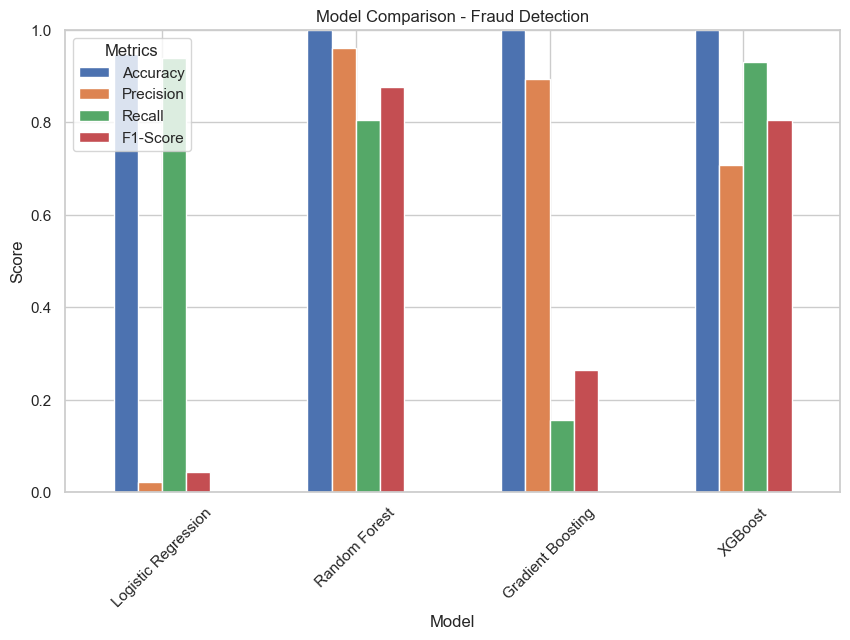

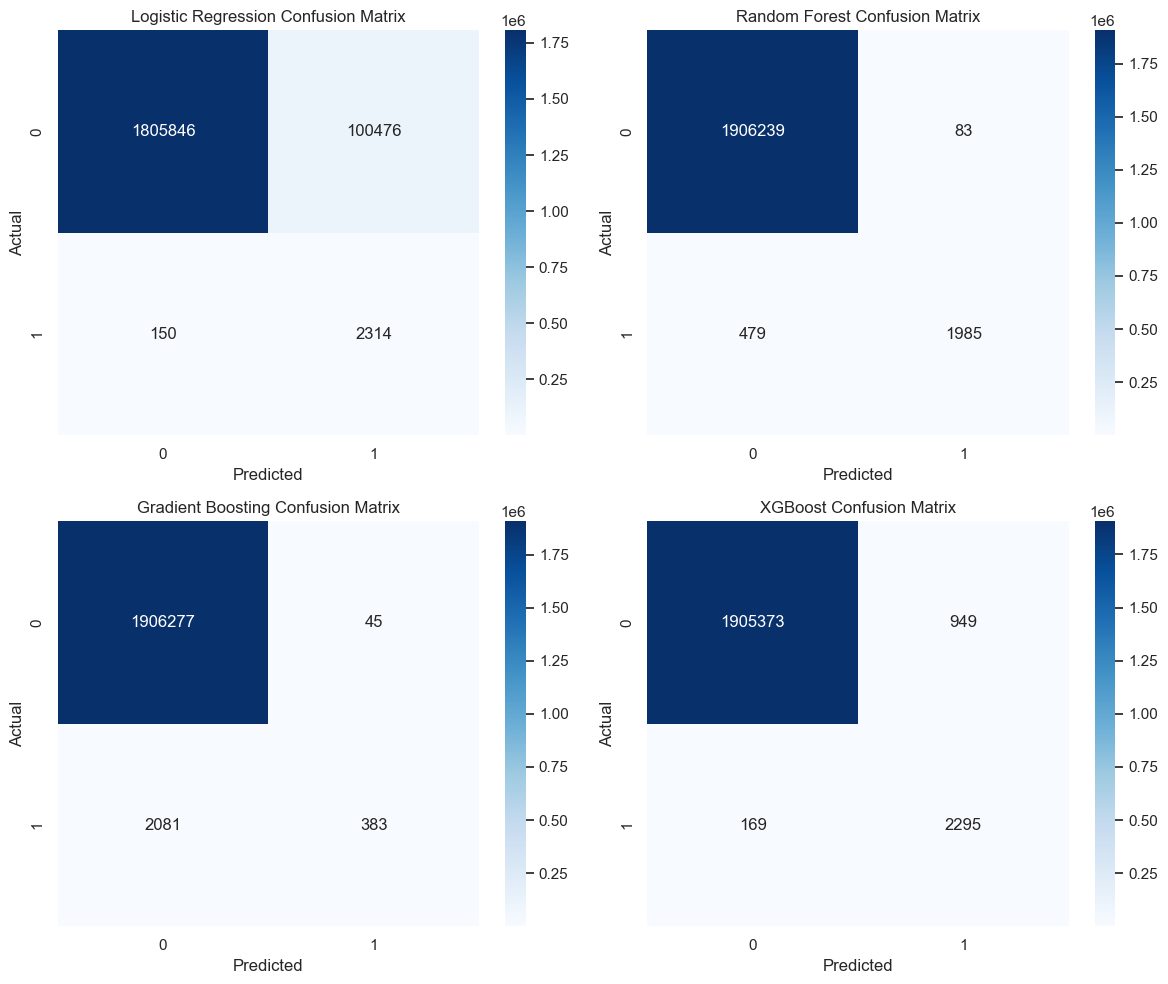

In [2]:
# --- Import Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# ML Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

# --- Load Processed Dataset ---
df = pd.read_csv("processed_fraud_dataset.csv")
print("Data Loaded:", df.shape)

# --- Prepare Data ---
categorical = ["type"]
numeric = ["amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest", "balanceDiffOrig", "balanceDiffDest"]

X = df.drop("isFraud", axis=1)
y = df["isFraud"]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# --- Preprocessing ---
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric),
        ('cat', OneHotEncoder(drop="first"), categorical)
    ],
    remainder="drop"
)

# --- Define Models ---
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=1000),
    "Random Forest": RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(scale_pos_weight=10, eval_metric='logloss', use_label_encoder=False)
}

# --- Train, Evaluate, and Collect Metrics ---
results = []
conf_matrices = {}

for name, model in models.items():
    pipeline = Pipeline([
        ('prep', preprocessor),
        ('clf', model)
    ])
    pipeline.fit(x_train, y_train)
    y_pred = pipeline.predict(x_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results.append([name, acc, prec, rec, f1])
    conf_matrices[name] = confusion_matrix(y_test, y_pred)
    print(f"\n🔹 {name} Results:")
    print(classification_report(y_test, y_pred))

# --- Create DataFrame of Metrics ---
results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1-Score"])
print("\nSummary of Model Performance:")
display(results_df)

# --- Plot Grouped Bar Chart ---
results_df.set_index("Model", inplace=True)
results_df.plot(kind="bar", figsize=(10,6))
plt.title("Model Comparison - Fraud Detection")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.legend(title="Metrics")
plt.show()

# --- Plot Confusion Matrices ---
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for i, (name, cm) in enumerate(conf_matrices.items()):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[i])
    axes[i].set_title(f"{name} Confusion Matrix")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Actual")

plt.tight_layout()
plt.show()


In [3]:
# --- Save Each Trained Model ---
import joblib
import os

# Create a folder to store models
os.makedirs("saved_models", exist_ok=True)

for name, model in models.items():
    # Recreate and retrain each model with preprocessing (optional to refit if you want exact pipelines)
    pipeline = Pipeline([
        ('prep', preprocessor),
        ('clf', model)
    ])
    pipeline.fit(x_train, y_train)
    
    # Define clean filename
    filename = f"saved_models/{name.replace(' ', '_').lower()}_model.pkl"
    
    # Save pipeline
    joblib.dump(pipeline, filename)
    print(f"Saved: {filename}")

print("\n All models have been saved successfully in the 'saved_models/' folder.")


Saved: saved_models/logistic_regression_model.pkl
Saved: saved_models/random_forest_model.pkl
Saved: saved_models/gradient_boosting_model.pkl
Saved: saved_models/xgboost_model.pkl

 All models have been saved successfully in the 'saved_models/' folder.
